<hr style="border:2px solid coral"></hr>

# Parabolic equations

<hr style="border:2px solid coral"></hr>

Many phenomena are modeled as diffusion processs. A classic example is the diffusion of heat through a medium (e.g. air, metals).  Other examples include diffusion of salt in sea water or pollutants in a river. 

The one dimensional parabolic equation is a *time dependent* problem given by the partial differential equation

\begin{equation}
q_t = \beta u_{xx} + S(x,t)
\end{equation}

where $q(x,t)$ is a concentation of some substance, $\beta$ is a diffusion coefficient, and $S(x,t)$ is a source term. 

### Backward Euler discretization

Using the *Backward Euler scheme*, we discretize the equation above in space and time to get an update for the solution at time $t_n = kn$, where $k$ is the time step.  This update is given by

\begin{eqnarray}
q^{n+1}_i & =  & q^n_i + k\left[\beta\frac{q_{i-1}^{n+1} - 2 q_i^{n+1} + q_{i+1}^{n+1}}{h^2}  + S(x_i,t_n)\right]
\end{eqnarray}

Terms involving the solution at time $t_{n+1}$ are moved to the right hand side to get

\begin{equation}
q_i^{n+1} - \frac{k\beta}{h^2}\left(q_{i-1}^{n+1} - 2 q_i^{n+1} + q_{i+1}^{n+1}\right)  = q^n_i + k S(x_i,t_n)
\end{equation}

Multiplying through by $-h^2/\beta k$, we can write the above linear system very similar to the elliptic problem. 

\begin{equation}
q_{i-1}^{n+1} - \left(2 + \frac{h^2}{\beta k}\right)q_{i}^{n+1} + q_{i+1}^{n+1} = -\frac{h^2}{k\beta} \left(q_i^n  + kS(x_i,t_n)\right) \equiv \mathbf F^n
\end{equation}

From this system, we see that 

1. Steady state is reached if $q_i^{n+1} = q_i^n$. In this case, the problem reduces to our familiar elliptic discretization of the steady state heat problem 

\begin{equation}
u_t = \beta u_{xx} + S(x,t) = 0
\end{equation}

or 
\begin{equation}
u_{xx} = -\frac{1}{\beta}S(x,t)
\end{equation}

2.  The resulting system of equations can be written as a linear system

\begin{equation}
\left(A -  \frac{h^2}{\beta k}I\right) \mathbf q^{n+1} = \mathbf F^n
\end{equation}

where $A$ is our standard $[1,-2,1]$ matrix. The resulting matrix is SPD, and so can be solved using our Conjugate Gradient solver. 


In [8]:
from matplotlib.pyplot import *
from numpy import *
from enum import Enum

In [9]:
# Conjugate gradient algorithm

from numpy.linalg import solve, norm

method_types = Enum('method_types', ['SD', 'CG'], start = 0)

def cg(A,F,kmax=10000,tol=1e-12, prt=False, \
       method=method_types.CG,x0 = None):
    if x0 is None:
        xk = zeros(F.shape)
    else:
        xk = x0
    rk = F - A@xk
    pk = rk
    for k in range(kmax):
        
        Apk = A@pk  
        pAp = pk.T@Apk
        if pAp == 0:
            print("pAp == 0")
            xkp1 = xk
            break
        rTr = rk.T@rk
        alpha = rTr/pAp
        xkp1 = xk + alpha*pk
        rkp1 = rk - alpha*Apk
        
        if method == method_types.SD:
            # Steepest descent directions 
            pkp1 = rkp1

        elif method == method_types.CG:
            # A-conjugate search directions 
            beta = rkp1.T@rkp1/rTr    
            pkp1 = rkp1 + beta*pk
        
        err = norm(rkp1,inf)
        itcount = k+1
        if prt:
            print(f"{k:5d} {err:12.4e}")
            
        if err < tol:
            break
        pk = pkp1
        rk = rkp1
        xk = xkp1
        
    xk = xkp1
    return xk,itcount        

In [10]:
# Construct (N-1)x(N-1) tridiagonal linear system.  

bc_types = Enum('bc_types', ['DIRICHLET', 'NEUMANN'], start = 0)

def get_linsys(N,a,b,beta,k,bc=bc_types.DIRICHLET):
    # Using a sparse matrix would be much faster for large N
    h = (b-a)/N
    x = linspace(a,b,N+1).reshape((N+1,1))
    if bc == bc_types.DIRICHLET:
        A = diag(ones(N-2),-1) - 2*diag(ones(N-1)) + diag(ones(N-2),1)
        x = x[1:-1]
        I = eye(N-1)
    elif bc == bc_types.NEUMANN:
        A = diag(ones(N),-1) - 2*diag(ones(N+1)) + diag(ones(N),1)
        A[0,0] = -1
        A[0,1] = 1
        A[-1,-2] = 1
        A[-1,-1] = -1
        I = eye(N+1)
        
    c = h**2/(beta*k)
    B = A - c*I
    return B, x

### Problem setup

Like the elliptic problem, we have to supply a domain interval $[a,b]$ and a mesh size $N$.  For our current problem, we may also want to supply a value for $\beta$. 

But because the problem is time dependent, we also need to supply a final time $T$, and a time step $k$. 

For this problem, we can set the time step $k \approx h$.  Then we compute the number of time steps needed to reach our final time $T$. 


In [11]:
def initial_condition(x):
    return exp(-200*(x-0.5)**2)

# User input
a = 0
b = 1
beta = 0.2
Tfinal = 1.0

# Numerical parameters 
N = 64
h = (b-a)/N

# Estimate a time step
k_est = h
M = int(Tfinal/k_est) + 1
k = Tfinal/M

A,x = get_linsys(N,a,b,beta,k,bc=bc_types.NEUMANN)

A typical time stepping algorithm requires an initial condition and a time stepping loop.  In each iteration of the loop, we will need to update the right hand side

\begin{equation}
\mathbf F^n = -\frac{h^2}{\beta k} \mathbf q^n
\end{equation}


<IPython.core.display.Javascript object>


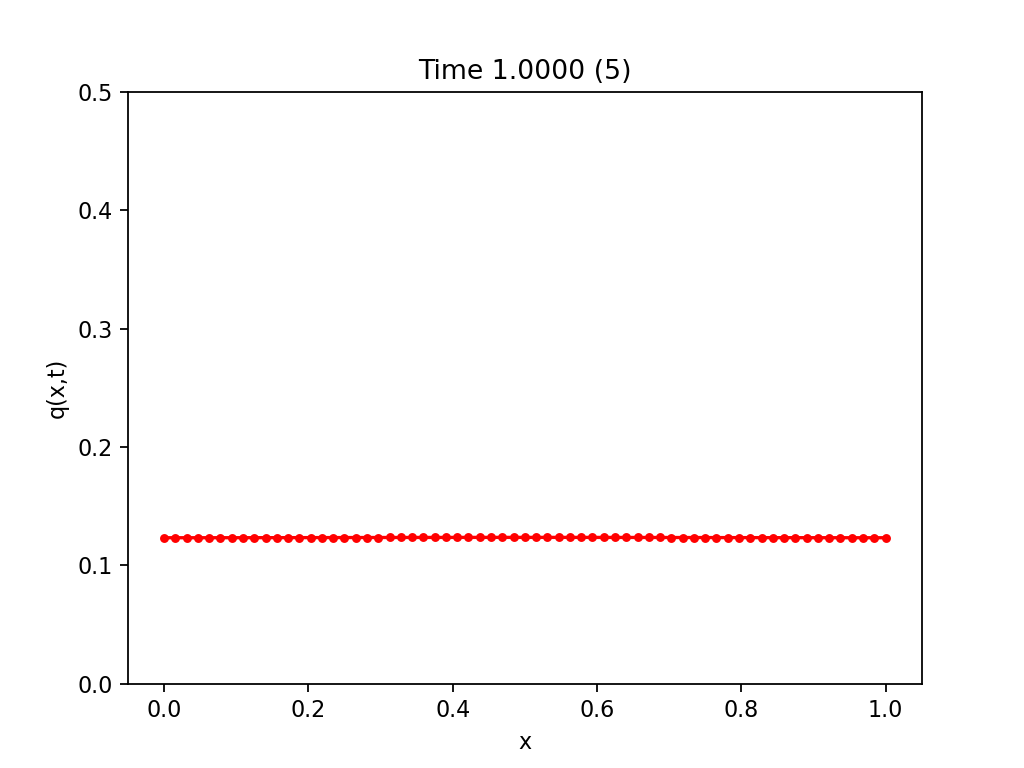

In [12]:
%matplotlib notebook

fig = figure(1)
clf()

qn = initial_condition(x)

hdl, = plot(x,qn,'r.-')

title_str = "Time {t:.4f} ({itcount:d})".format

tstr = title_str(t=0,itcount=0)
title(tstr)

xlabel('x')
ylabel('q(x,t)')
ylim([0,0.5])

fig.canvas.draw() 

pause(1)

prt = 0
for n in range(M+1):
    t = k*n
    Fn = -h**2/(beta*k)*qn
    qnp1,itcount = cg(A,Fn,prt=0,x0=qn)
    if prt:
        print(f"{n:5d} {itcount:8d}")
    
    hdl.set_ydata(qnp1)    
    
    tstr = title_str(t=t,itcount=itcount)
    title(tstr)
    ylim([0,0.5])
    
    fig.canvas.draw();       
        
    pause(0.5)
    
    qn = qnp1


<hr style="border:2px solid coral"></hr>

## Boundary conditions

<hr style="border:2px solid coral"></hr>

Like elliptic problems, we also need boundary conditions for the heat equation solver.  Fortunately, they are implemented in exactly the same way as for the elliptic problem. 